## Setup

In [1]:
!git clone https://github.com/neuspell/neuspell
%cd neuspell

Cloning into 'neuspell'...
remote: Enumerating objects: 689, done.
remote: Counting objects: 100% (492/492), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 689 (delta 304), reused 325 (delta 161), pack-reused 197
Receiving objects: 100% (689/689), 74.44 MiB | 27.48 MiB/s, done.
Resolving deltas: 100% (330/330), done.
/content/neuspell


In [2]:
!pip install -e .

Obtaining file:///content/neuspell
     |████████████████████████████████| 2.3MB 6.9MB/s 
     |████████████████████████████████| 1.2MB 41.4MB/s 
     |████████████████████████████████| 133kB 45.9MB/s 
     |████████████████████████████████| 3.3MB 50.5MB/s 
     |████████████████████████████████| 901kB 44.8MB/s 
     |████████████████████████████████| 133kB 42.0MB/s 
     |████████████████████████████████| 7.6MB 39.0MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
ERROR: botocore 1.20.84 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
  Running setup.py develop for neuspell


In [3]:
!pip install urllib3==1.25.4

     |████████████████████████████████| 133kB 8.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
!pip install folium==0.2.1

     |████████████████████████████████| 71kB 5.0MB/s 
  Created wheel for folium: filename=folium-0.2.1-cp37-none-any.whl size=79979 sha256=5f16e2285956cbddf98dc79aae46c8f876bac350f1053c3c079d3edcbfff7871
  Stored in directory: /root/.cache/pip/wheels/b8/09/f0/52d2ef419c2aaf4fb149f92a33e0008bdce7ae816f0dd8f0c5
Successfully built folium
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


In [5]:
!pip install -r extras-requirements.txt

Obtaining file:///content/neuspell (from -r extras-requirements.txt (line 1))
Obtaining file:///content/neuspell (from -r extras-requirements.txt (line 2))
     |████████████████████████████████| 522kB 7.1MB/s 
     |████████████████████████████████| 266kB 12.4MB/s 
     |████████████████████████████████| 122kB 13.8MB/s 
  Created wheel for jsonnet: filename=jsonnet-0.17.0-cp37-cp37m-linux_x86_64.whl size=3388781 sha256=c329c4b75f54e7bb0d6ccb1e4068da316ecd90cc9f1c770c63a1ae8518c4bb9f
  Stored in directory: /root/.cache/pip/wheels/26/7a/37/7dbcc30a6b4efd17b91ad1f0128b7bbf84813bd4e1cfb8c1e3
  Created wheel for overrides: filename=overrides-3.1.0-cp37-none-any.whl size=10174 sha256=3da4a2fdd217fcb4ae2c7dbd651b3d8a14de0d1575fa325bdb7a48a5da02d6b8
  Stored in directory: /root/.cache/pip/wheels/5c/24/13/6ef8600e6f147c95e595f1289a86a3cc82ed65df57582c65a9
Successfully built jsonnet overrides
ERROR: allennlp 1.5.0 has requirement torch<1.8.0,>=1.6.0, but you'll have torch 1.8.1+cu101 which is i

In [6]:
!pip install torch==1.6.0

     |████████████████████████████████| 748.8MB 24kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: allennlp 1.5.0 has requirement transformers<4.3,>=4.1, but you'll have transformers 4.6.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [7]:
!pip install transformers==4.1

     |████████████████████████████████| 1.5MB 8.1MB/s 
     |████████████████████████████████| 2.9MB 36.5MB/s 
  Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Found existing installation: transformers 4.6.1
    Uninstalling transformers-4.6.1:
      Successfully uninstalled transformers-4.6.1


In [8]:
import neuspell
%cd data/traintest
!python download_datafiles.py 
%cd /content/neuspell

data folder is set to `/content/neuspell/neuspell/../data` script



/content/neuspell/data/traintest
./wo_context created
/content/neuspell


## Data preparation

In [9]:
import os, sys

from tqdm import tqdm
import os, sys
import numpy as np
import re
import time
from typing import List

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

from neuspell.seq_modeling.helpers import progressBar
from neuspell.seq_modeling.helpers import load_vocab_dict, save_vocab_dict
from neuspell.seq_modeling.helpers import load_data, train_validation_split, get_char_tokens, get_tokens, num_unk_tokens
from neuspell.seq_modeling.helpers import batch_iter, labelize, tokenize, char_tokenize
from neuspell.seq_modeling.helpers import untokenize, untokenize_without_unks, untokenize_without_unks2, get_model_nparams
from neuspell.seq_modeling.helpers import batch_accuracy_func

from neuspell.seq_modeling.helpers2 import get_line_representation, get_lines

from neuspell.seq_modeling.models import CharCNNWordLSTMModel

from neuspell.seq_modeling.evals import get_metrics

import matplotlib.pyplot as plt

In [10]:
from neuspell.seq_modeling.cnnlstm import load_model
from neuspell.seq_modeling.cnnlstm import model_predictions
from neuspell.seq_modeling.cnnlstm import model_inference

In [11]:
train_data = load_data('/content/neuspell/data/traintest/','test.1blm','test.1blm.noise.prob')

273134it [00:00, 324737.88it/s]
273134it [00:00, 1240649.46it/s]

loaded tuples of (corr,incorr) examples from /content/neuspell/data/traintest/


In [ ]:
train_data, valid_data = train_validation_split(train_data, 0.90, seed=11690)

In [ ]:
print("length of train data:",len(train_data))
print("length of valid data:",len(valid_data))

length of train data: 245821
length of valid data: 27313


In [ ]:
train_data[0]

('2007 May - Parliament brings forward national elections to 22 July to try end the standoff between secularists and Islamists over the choice of the next president .',
 '2007 May - Parliament brigs forword nationar elections to 22 July to try end the standoff between secularists and Islamist over the choice of the nezt president .')

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model training

In [13]:
##########################################################################################################################################
# Step-1: Create vocab file. This serves as the target vocab file and we use the defined model's default huggingface
# tokenizer to tokenize inputs appropriately.
################################################################################################################################################
vocab_ref = {}
vocab = get_tokens([i[0] for i in train_data],
                           keep_simple=True,
                           min_max_freq=(2,float("inf")),
                           topk=100000,
                           intersect=vocab_ref,
                           load_char_tokens=True)

100%|██████████| 273134/273134 [00:01<00:00, 144445.86it/s]


Total tokens found: 164450


  0%|          | 0/273134 [00:00<?, ?it/s]

Total tokens retained: 147155
Total tokens retained: 71704
Total tokens retained: 71704
loading character tokens


100%|██████████| 273134/273134 [00:01<00:00, 185996.42it/s]

number of unique chars found: 98
{'<<CHAR_UNK>>': 0, '<<CHAR_PAD>>': 1, '<<CHAR_START>>': 2, '<<CHAR_END>>': 3, 'D': 4, ' ': 5, "'": 6, 'S': 7, 'o': 8, 'u': 9, 'z': 10, 'a': 11, 'i': 12, 's': 13, 'm': 14, 'e': 15, 'd': 16, 't': 17, 'h': 18, 'r': 19, 'c': 20, 'g': 21, 'n': 22, 'w': 23, 'I': 24, '-': 25, 'y': 26, 'v': 27, 'l': 28, '.': 29, ',': 30, 'U': 31, 'G': 32, '2': 33, '0': 34, '3': 35, 'p': 36, 'b': 37, 'O': 38, 'f': 39, 'x': 40, 'N': 41, 'Y': 42, 'k': 43, 'B': 44, 'T': 45, '1': 46, '9': 47, '7': 48, 'W': 49, ':': 50, 'M': 51, 'J': 52, 'L': 53, '$': 54, '4': 55, '5': 56, 'F': 57, 'P': 58, 'H': 59, 'q': 60, 'j': 61, 'R': 62, 'C': 63, '"': 64, 'K': 65, 'A': 66, '(': 67, ')': 68, 'E': 69, 'V': 70, '?': 71, 'Z': 72, '|': 73, '6': 74, ';': 75, '8': 76, 'Q': 77, '/': 78, '&': 79, '_': 80, 'X': 81, '%': 82, '!': 83, '*': 84, '[': 85, ']': 86, '+': 87, '@': 88, '#': 89, '<': 90, '>': 91, '=': 92, '^': 93, '{': 94, '}': 95, '~': 96, '\\': 97}


In [ ]:
#################################
# Step-2: Initialize a model
#################################

model = load_model(vocab)

# Create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Number of parameters in the model: 79608017


In epoch: 1
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.1703 || batch_loss: 0.9332 || avg_batch_loss: 1.6672 || batch_acc: 0.0489 || avg_batch_acc: 0.0489 
Epoch 1 train_loss: 1.6672169416948892
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.0497 || batch_loss: 0.3569 || avg_batch_loss: 0.5627 || batch_acc: 0.9360 || avg_batch_acc: 0.9090 
Epoch 1 valid_loss: 0.562748094108959
In epoch: 2
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.1670 || batch_loss: 0.4164 || avg_batch_loss: 0.5622 || batch_acc: 0.9029 || avg_batch_acc: 0.9029 
Epoch 2 train_loss: 0.5621592247006608
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.0500 || batch_loss: 0.1718 || avg_batch_loss: 0.3129 || batch_acc: 0.9557 || avg_batch_acc: 0.9375 
Epoch 2 valid_loss: 0.31294477861854453


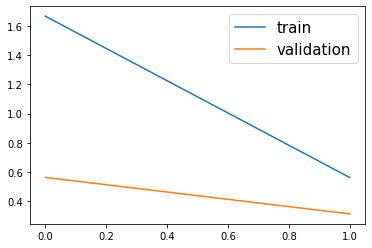

In epoch: 3
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.1729 || batch_loss: 0.2654 || avg_batch_loss: 0.3494 || batch_acc: 0.9603 || avg_batch_acc: 0.9603 
Epoch 3 train_loss: 0.3493816886592799
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.0491 || batch_loss: 0.1049 || avg_batch_loss: 0.2349 || batch_acc: 0.9704 || avg_batch_acc: 0.9471 
Epoch 3 valid_loss: 0.2349355196977248


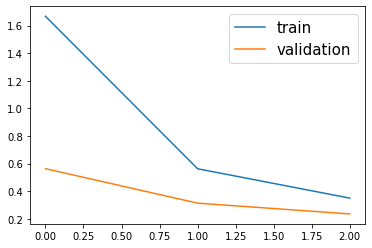

In epoch: 4
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.1776 || batch_loss: 0.3267 || avg_batch_loss: 0.2542 || batch_acc: 0.9614 || avg_batch_acc: 0.9614 
Epoch 4 train_loss: 0.25424295784292106
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.0503 || batch_loss: 0.0880 || avg_batch_loss: 0.2029 || batch_acc: 0.9778 || avg_batch_acc: 0.9523 
Epoch 4 valid_loss: 0.20288373932102804


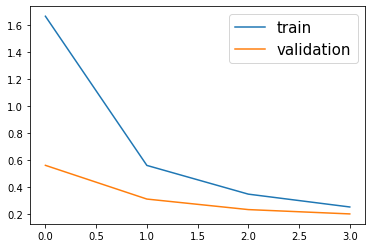

In epoch: 5
train_data size: 245821
Percent: [----------------------------->] 99% || batch_time: 0.1741 || batch_loss: 0.2407 || avg_batch_loss: 0.2012 || batch_acc: 0.9718 || avg_batch_acc: 0.9718 

KeyboardInterrupt: ignored

In [ ]:
########################################
# Step-3: training and validation
########################################
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

START_EPOCH = 1
N_EPOCHS = 8
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
max_dev_acc, argmax_dev_acc = -1, -1
patience = 100

MODEL_NAME = "CNN-LSTM"
total_train_loss = []
total_val_loss = []


for epoch_id in range(START_EPOCH,N_EPOCHS+1):
  # check for patience
  if (epoch_id-argmax_dev_acc)>patience:
    print("patience count reached. early stopping initiated")
    print("max_dev_acc: {}, argmax_dev_acc: {}".format(max_dev_acc, argmax_dev_acc))
    break
  # print epoch
  print(f"In epoch: {epoch_id}")
  # train loss and backprop
  train_loss = 0.
  train_acc = 0.
  train_acc_count = 0.
  print("train_data size: {}".format(len(train_data)))
  train_data_iter = batch_iter(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
  nbatches = int(np.ceil(len(train_data)/TRAIN_BATCH_SIZE))
  
  for batch_id, (batch_labels,batch_sentences) in enumerate(train_data_iter):
    optimizer.zero_grad()
    st_time = time.time()
    # set batch data
    batch_labels, batch_lengths = labelize(batch_labels, vocab)
    batch_idxs, batch_lengths_ = char_tokenize(batch_sentences, vocab)
    assert (batch_lengths_==batch_lengths).all()==True
    batch_idxs = [batch_idxs_.to(DEVICE) for batch_idxs_ in batch_idxs]
    batch_lengths = batch_lengths.to(DEVICE)
    batch_labels = batch_labels.to(DEVICE)
    # forward
    model.train()
    loss = model(batch_idxs, batch_lengths, targets=batch_labels)
    batch_loss = loss.cpu().detach().numpy()
    train_loss += batch_loss
    # backward
    loss.backward()
    optimizer.step()
    # compute accuracy in numpy
    if batch_id%10000==0:
      train_acc_count += 1
      model.eval()
      with torch.no_grad():
        _, batch_predictions = model(batch_idxs, batch_lengths, targets=batch_labels)
        model.train()
        batch_labels = batch_labels.cpu().detach().numpy()
        batch_lengths = batch_lengths.cpu().detach().numpy()
        ncorr,ntotal = batch_accuracy_func(batch_predictions,batch_labels,batch_lengths)
        batch_acc = ncorr/ntotal
        train_acc += batch_acc 

    # update progress
    progressBar(batch_id+1,
          int(np.ceil(len(train_data) / TRAIN_BATCH_SIZE)), 
          ["batch_time","batch_loss","avg_batch_loss","batch_acc","avg_batch_acc"],
          [time.time()-st_time,batch_loss,train_loss/(batch_id+1),batch_acc,train_acc/train_acc_count]) 
  print(f"\nEpoch {epoch_id} train_loss: {train_loss/(batch_id+1)}")
  
  mean_batch_loss = train_loss / nbatches
  total_train_loss.append(mean_batch_loss)


  # save model and optimizer every epoch
  model_name = MODEL_NAME + "_epoch_" + str(epoch_id) + '.pt'
  torch.save(model.state_dict(),
            '/content/drive/MyDrive/NLP/CW2/'+model_name)
    
  # save optimizer
  optimizer_name = MODEL_NAME + "_optimizer_epoch_" + str(epoch_id) + '.pt'
  torch.save(optimizer.state_dict(), 
        '/content/drive/MyDrive/NLP/CW2/'+optimizer_name)


  # valid loss
  valid_loss = 0.
  valid_acc = 0.
  print("valid_data size: {}".format(len(valid_data)))
  valid_data_iter = batch_iter(valid_data, batch_size=VALID_BATCH_SIZE, shuffle=False)
  val_nbatches = int(np.ceil(len(valid_data)/VALID_BATCH_SIZE))

  for batch_id, (batch_labels,batch_sentences) in enumerate(valid_data_iter):
    st_time = time.time()
    # set batch data
    batch_labels, batch_lengths = labelize(batch_labels, vocab)
    batch_idxs, batch_lengths_ = char_tokenize(batch_sentences, vocab)
    assert (batch_lengths_==batch_lengths).all()==True
    batch_idxs = [batch_idxs_.to(DEVICE) for batch_idxs_ in batch_idxs]
    batch_lengths = batch_lengths.to(DEVICE)
    batch_labels = batch_labels.to(DEVICE)
    # forward
    model.eval()
    with torch.no_grad():
      batch_loss, batch_predictions = model(batch_idxs, batch_lengths, targets=batch_labels)
    model.train()        
    valid_loss += batch_loss
    # compute accuracy in numpy
    batch_labels = batch_labels.cpu().detach().numpy()
    batch_lengths = batch_lengths.cpu().detach().numpy()
    ncorr,ntotal = batch_accuracy_func(batch_predictions,batch_labels,batch_lengths)
    batch_acc = ncorr/ntotal
    valid_acc += batch_acc
    # update progress
    progressBar(batch_id+1,
          int(np.ceil(len(valid_data) / VALID_BATCH_SIZE)), 
          ["batch_time","batch_loss","avg_batch_loss","batch_acc","avg_batch_acc"], 
          [time.time()-st_time,batch_loss,valid_loss/(batch_id+1),batch_acc,valid_acc/(batch_id+1)]) 
  print(f"\nEpoch {epoch_id} valid_loss: {valid_loss/(batch_id+1)}")
  
  mean_val_loss = valid_loss / val_nbatches
  total_val_loss.append(mean_val_loss)
    
  if epoch_id >= 2:
      plt.figure(epoch_id)
      plt.plot(total_train_loss, label='train')
      plt.plot(total_val_loss, label='validation')
      plt.legend(fontsize=15)
      plt.show()

## Model testing

#### load pretrained model

In [15]:
model = load_model(vocab)
model = model.cuda()
pretrained_model_name = 'CNN-LSTM_epoch_4.pt'
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/CW2/'+pretrained_model_name))

Number of parameters in the model: 83478417


RuntimeError: ignored

#### load test data sets: jfleg and bea60k

In [ ]:
# load test data jfleg
test_data = load_data('/content/neuspell/data/traintest/','test.jfleg','test.jfleg.noise')
test_data_2 = load_data('/content/neuspell/data/traintest/','test.bea60k','test.bea60k.noise')

1601it [00:00, 351980.33it/s]
1601it [00:00, 945519.67it/s]
0it [00:00, ?it/s]

loaded tuples of (corr,incorr) examples from /content/neuspell/data/traintest/


63044it [00:00, 454756.16it/s]
63044it [00:00, 1566066.92it/s]

loaded tuples of (corr,incorr) examples from /content/neuspell/data/traintest/


#### Inference on jfleg dataset

In [ ]:
predictions = model_predictions(model,test_data,vocab,DEVICE)

2it [00:00, 17.41it/s]

###############################################
data size: 1601


101it [00:05, 17.09it/s]

total inference time for this data is: 5.917255 secs


In [ ]:
model_inference(model = model, data = test_data, topk=1, device = DEVICE, vocab_=vocab)

2it [00:00, 18.75it/s]

###############################################
data size: 1601


101it [00:05, 17.13it/s]


Epoch None valid_loss: 0.18253070720941714
total inference time for this data is: 5.901403 secs
###############################################
total token count: 33625
_corr2corr:31015, _corr2incorr:569, _incorr2corr:1527, _incorr2incorr:514
accuracy is 0.9677918215613383
word correction rate is 0.7481626653601176
###############################################


#### Inference on bea60k dataset

In [ ]:
model_inference(model = model, data = test_data_2, topk=1, device = DEVICE, vocab_=vocab)

2it [00:00, 16.80it/s]

###############################################
data size: 63044


3941it [03:12, 20.43it/s]


Epoch None valid_loss: 0.28121077468010475
total inference time for this data is: 192.883864 secs
###############################################
total token count: 1032061
_corr2corr:939523, _corr2incorr:22474, _incorr2corr:47721, _incorr2incorr:22343
accuracy is 0.9565752411921389
word correction rate is 0.6811058460835807
###############################################


## Loss Check

In [ ]:
total_train_loss

[1.6672169416948892,
 0.5621592247006608,
 0.3493816886592799,
 0.25424295784292106]

In [ ]:
total_val_loss

[0.562748094108959,
 0.31294477861854453,
 0.2349355196977248,
 0.20288373932102804]